# Exercise 1: Introduction to pyiron

## Imports and and working with projects

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [3]:
pr = Project("demo")

# To delete all jobs and start from scratch, uncomment the next line
#pr.remove_jobs(recursive=True)

## Creating and manipulating structures

In [4]:
# atomistic structures
Al_struct = pr.create_ase_bulk("Al", cubic=True).repeat([2, 2, 4])
Al_struct.plot3d()

_ColormakerRegistry()

NGLWidget()

In [5]:
Al_struct[36] = "Cu"
Al_struct.plot3d(particle_size=3)

NGLWidget()

In [6]:
del Al_struct[17]
Al_struct.plot3d(particle_size=3)

NGLWidget()

### Creating bulk water consisting of several water molecules

In [7]:
cell = np.eye(3) * 10
r_O = [0, 0, 0]
r_H1 = [0.0, 0.7, 0.7]
r_H2 = [0.0, 0.7, -0.7]
water_molecule = pr.create_atoms("H2O", positions=[r_H1, r_H2, r_O], cell=cell)
water_molecule.center()
water_molecule.set_cell(water_molecule.cell * water_molecule.get_density() ** (1/3), scale_atoms=False)
water_molecule.get_density()
water_box = water_molecule.repeat(3)
water_box.center_coordinates_in_unit_cell()
water_box.plot3d(spacefill=False)

NGLWidget()

### Creating an Al supercell with interstitial H

#### Create Al sublattice

In [8]:
Al_struct = pr.create_ase_bulk("Al", cubic=True)

#### Create H interstitial sublattice

Translate the H position by half the unit cell vectors.

In [11]:
H_int = Al_struct.copy()
H_int[:] = "H"
H_int.positions += 0.5 * H_int.cell @ (1, 1, 1)

#### Create a 2x2x4 supercell for both lattices

In [12]:
Al_struct.set_repeat([2, 2, 4])
H_int.set_repeat([2, 2, 4])

#### Occupy the H sublattice randomly with 10 H atoms 

In [13]:
rand_int = np.arange(0, len(H_int))
np.random.shuffle(rand_int)
H_int = H_int[rand_int[:10]]

#### Combine Al and H sublattice in same supercell

In [14]:
AlH_struct = Al_struct + H_int
AlH_struct.plot3d(particle_size=3)

NGLWidget()

## Perform a MD simulation of the AlH supercell using LAMMPS

### Setup the Lammps calculation

In [15]:
job_lammps = pr.create_job(job_type=pr.job_type.Lammps, job_name= "AlH_lammps")
job_lammps.structure = AlH_struct
print(job_lammps.list_potentials())
job_lammps.potential =  'Al_H_Ni_Angelo_eam'
job_lammps.calc_md(temperature=600, n_ionic_steps=10000)

['Al_H_Ni_Angelo_eam', '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1', '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1', 'EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_418978237058_005']


In [16]:
job_lammps.run()

The job AlH_lammps was saved and received the ID: 510


### Animate MD trajectories

In [17]:
job_lammps.animate_structure(particle_size=1)

NGLWidget(max_frame=100)

### Analyze trajectories in more detail

In [18]:
H_indices = AlH_struct.select_index("H")
Al_indices = AlH_struct.select_index("Al")
H_indices

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

#### Plot Al trajectories in grey, H ones in red

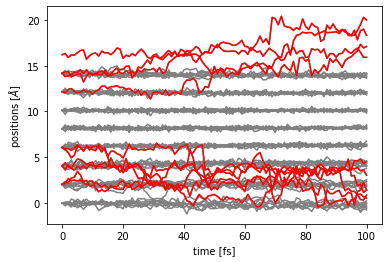

In [19]:
plt.plot(job_lammps.output.unwrapped_positions[:, :, 2], color="grey")
plt.plot(job_lammps.output.unwrapped_positions[:, H_indices, 2], color="red")
plt.xlabel("time [fs]")
plt.ylabel("positions [$\AA$]");

### Visualize the last MD configuration

In [20]:
md_struct = job_lammps.get_structure(iteration_step=-1)
md_struct.plot3d(particle_size=2)

NGLWidget()

### Take the last configuration and perform structure relaxation (including cell relaxation - pressure=0)

In [21]:
job_lammps_minimize = pr.create_job(pr.job_type.Lammps, "AlH_minimize")
job_lammps_minimize.structure = md_struct

In [22]:
job_lammps_minimize.potential = job_lammps.potential.copy() # this looks not so nice, could we take a copy of job_lammps?

In [23]:
job_lammps_minimize.calc_minimize(pressure=0)
job_lammps_minimize.run()

The job AlH_minimize was saved and received the ID: 511


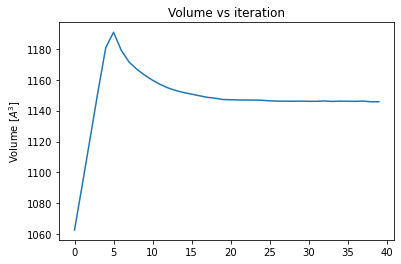

In [24]:
plt.plot(job_lammps_minimize.output.volume)
plt.title('Volume vs iteration')
plt.ylabel('Volume [$A^3$]');

In [25]:
job_lammps_minimize.animate_structure(particle_size=1)

NGLWidget(max_frame=39)

In [26]:
job_lammps_minimize.get_structure(-1).plot3d(particle_size=2)

NGLWidget()

## Analysis

### Plot Al-Al and H-H pair correlation function of the last MD structure

This is done using the `get_neighbors()` function

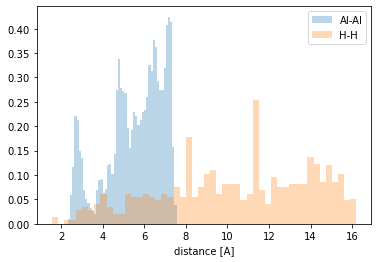

In [27]:
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_md = md_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.xlabel('distance [A]')
plt.legend();

### Plot Al-Al and H-H pair correlation function after structure and cell relaxation 

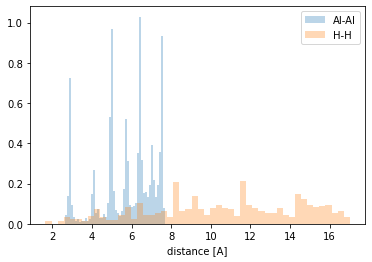

In [28]:
min_struct = job_lammps_minimize.get_structure(-1)
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_min = min_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.xlabel('distance [A]')
plt.legend();

### Compare Al-Al pair correlation before and after relaxation

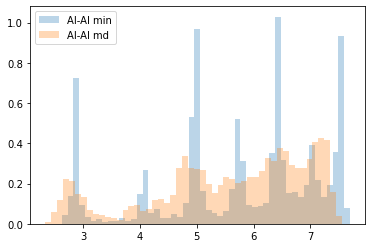

In [29]:
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al min")
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al md")
plt.legend();

### Utility functions

In [30]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,510,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/,2020-08-10 09:31:57.684716,2020-08-10 09:31:59.954779,2.0,pyiron@susan#1,Lammps,0.1,None,None
1,511,finished,Al64H10,AlH_minimize,/AlH_minimize,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/,2020-08-10 09:32:07.019388,2020-08-10 09:32:08.244496,1.0,pyiron@susan#1,Lammps,0.1,None,None


In [31]:
job_md_reloaded = pr.load("AlH_lammps")

In [32]:
job_min_reloaded = pr.load("AlH_minimize")

In [33]:
type(job_min_reloaded)

pyiron.lammps.lammps.Lammps

In [34]:
pr

{'groups': [], 'nodes': ['AlH_lammps', 'AlH_minimize']}

In [35]:
pr["AlH_lammps"]

{'groups': ['input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [36]:
pr["AlH_lammps/input"]

{'groups': ['control_inp', 'generic', 'potential', 'potential_inp', 'structure'], 'nodes': ['generic_dict', 'interactive']}

In [37]:
pr["AlH_lammps/output/generic/forces"].shape,  pr["AlH_lammps/output/generic/energy_tot"].shape

((101, 74, 3), (101,))

## Energy volume curves for Al

### Manual setup and analysys

In [38]:
pr = Project("demo/Al_murnaghan_manual")

In [39]:
a_list = np.linspace(3.9, 4.1, 11)
for a in a_list:
    job_name = "Al_a_{}".format(a).replace(".", "_")
    job = pr.create_job(pr.job_type.Lammps, job_name)
    job.structure = pr.create_ase_bulk("Al", a=a, cubic=True)
    job.potential = 'Al_H_Ni_Angelo_eam'
    job.calc_minimize()
    job.run()

The job Al_a_3_9 was saved and received the ID: 512
The job Al_a_3_92 was saved and received the ID: 513
The job Al_a_3_94 was saved and received the ID: 514
The job Al_a_3_96 was saved and received the ID: 515
The job Al_a_3_98 was saved and received the ID: 516
The job Al_a_4_0 was saved and received the ID: 517
The job Al_a_4_02 was saved and received the ID: 518
The job Al_a_4_04 was saved and received the ID: 519
The job Al_a_4_06 was saved and received the ID: 520
The job Al_a_4_08 was saved and received the ID: 521
The job Al_a_4_1 was saved and received the ID: 522


In [40]:
pr.job_table();

### Analysis: Loading vs inspecting jobs

The data from these calculations are retreived either by loading each of these jobs or by inspecting them (from their hdf5 files).

In [41]:
job_loaded = pr.load("Al_a_3_9")
struct = job_loaded.get_structure()
job_loaded.output.energy_tot, job_loaded["output/generic/energy_tot"], type(job_loaded)

(array([-13.21258266, -13.21258266]),
 array([-13.21258266, -13.21258266]),
 pyiron.lammps.lammps.Lammps)

In [42]:
job_inspect = pr.inspect("Al_a_3_9")
job_loaded["output/generic/energy_tot"], type(job_inspect)

(array([-13.21258266, -13.21258266]), pyiron.base.job.path.JobPath)

So why use the inspect mode if recreating the object gives access to all it's pyiron functions? The inspect mode is actually much faster if you only want to access certain values without recreating the entire job object.

CPU times: user 325 ms, sys: 28.9 ms, total: 354 ms
Wall time: 146 ms


pyiron.base.job.path.JobPath

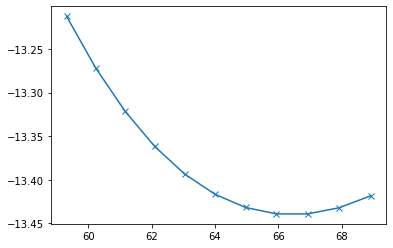

In [43]:
%%time
convert_to_object = False # True to load the job
vol_list = list()
energy_list = list()
# Set recursive=False to only go over the higher levels and not return jobs from subprojects
for job in pr.iter_jobs(convert_to_object=convert_to_object, recursive=False):
    if job.status == "finished":
        vol_list.append(job["output/generic/volume"][-1])
        energy_list.append(job["output/generic/energy_tot"][-1])
plt.plot(vol_list, energy_list, "-x")
type(job)

## Energy-Volume curves using predefined modules

We will now use the predefined Murnaghan module to compute equilibrium T=0K properties 

In [44]:
pr = Project("demo/murnaghan_automatic")

### Setup of the Murnaghan job and a reference calculation for the parameters

In [45]:
# Initialize the Murnaghan "job"
murn = pr.create_job(pr.job_type.Murnaghan, "murn_test")
# Create a reference job which contains all simulation parameters
job_ref = pr.create_job(pr.job_type.Lammps, "Al_ref")
job_ref.structure = pr.create_ase_bulk("Al", cubic=True)
job_ref.potential = 'Al_H_Ni_Angelo_eam'
job_ref.calc_minimize()
murn.ref_job = job_ref

The Murnaghan job creates individual LAMMPS calculations with a strained unitcell

In [46]:
murn.run()

The job murn_test was saved and received the ID: 523
The job strain_0_9 was saved and received the ID: 524
The job strain_0_92 was saved and received the ID: 525
The job strain_0_94 was saved and received the ID: 526
The job strain_0_96 was saved and received the ID: 527
The job strain_0_98 was saved and received the ID: 528
The job strain_1_0 was saved and received the ID: 529
The job strain_1_02 was saved and received the ID: 530
The job strain_1_04 was saved and received the ID: 531
The job strain_1_06 was saved and received the ID: 532
The job strain_1_08 was saved and received the ID: 533
The job strain_1_1 was saved and received the ID: 534
job_id:  524 finished
job_id:  525 finished
job_id:  526 finished
job_id:  527 finished
job_id:  528 finished
job_id:  529 finished
job_id:  530 finished
job_id:  531 finished
job_id:  532 finished
job_id:  533 finished
job_id:  534 finished


In [47]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,523,finished,Al4,murn_test,/murn_test,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/,2020-08-10 09:32:47.835567,2020-08-10 09:33:00.144751,12.0,pyiron@susan#1#11/11,Murnaghan,0.3.0,None,NaN
1,524,finished,Al4,strain_0_9,/strain_0_9,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:48.556631,2020-08-10 09:32:48.940215,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
2,525,finished,Al4,strain_0_92,/strain_0_92,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:49.706802,2020-08-10 09:32:50.124566,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
3,526,finished,Al4,strain_0_94,/strain_0_94,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:50.842040,2020-08-10 09:32:51.218276,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
4,527,finished,Al4,strain_0_96,/strain_0_96,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:51.947845,2020-08-10 09:32:52.321993,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
5,528,finished,Al4,strain_0_98,/strain_0_98,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:53.048372,2020-08-10 09:32:53.521272,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
6,529,finished,Al4,strain_1_0,/strain_1_0,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:54.248300,2020-08-10 09:32:54.589939,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
7,530,finished,Al4,strain_1_02,/strain_1_02,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:55.250989,2020-08-10 09:32:55.600327,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
8,531,finished,Al4,strain_1_04,/strain_1_04,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:56.283676,2020-08-10 09:32:56.638992,0.0,pyiron@susan#1,Lammps,0.1,None,523.0
9,532,finished,Al4,strain_1_06,/strain_1_06,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-08-10 09:32:57.323763,2020-08-10 09:32:57.721968,0.0,pyiron@susan#1,Lammps,0.1,None,523.0


### Plotting and inspecting the murnaghan output

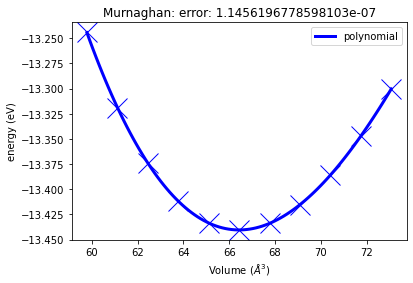

In [48]:
murn.plot()

In [49]:
murn["output"]

{'groups': ['structure'], 'nodes': ['energy', 'equilibrium_b_prime', 'equilibrium_bulk_modulus', 'equilibrium_energy', 'equilibrium_volume', 'error', 'id', 'volume']}

In [50]:
murn["output/equilibrium_volume"] ** (1/3), murn["output/equilibrium_bulk_modulus"]

(4.049953713580602, 81.04044546401637)

In [51]:
murn.fit_dict

{'poly_fit': array([-9.56553731e-05,  2.28697903e-02, -1.77209828e+00,  3.13985247e+01]),
 'fit_type': 'polynomial',
 'fit_order': 3,
 'volume_eq': 66.42784738704796,
 'energy_eq': -13.44039661441169,
 'bulkmodul_eq': 81.04044546401637,
 'b_prime_eq': 4.006907327547067,
 'least_square_error': 1.1456196778598103e-07}

In [52]:
job_child = murn[0]

## Energy-volume curves for a variety of Al potentials

Since an E-V curve can be calculated quite easily, we can now do this for a range of available Al potentials (keep in mind that some of these potentials might fail)

In [53]:
pr = Project("demo/potential_scan")
###pr.remove_jobs()

### Looping over available potenitals

In [54]:
#Chosing only a few potentials since there are lots of Al potentials

potential_list = job_child.list_potentials()[0:10]

In [55]:
for pot in potential_list:
    pot_str = pot.replace("-", "_")
    # open a subproject within a project
    with pr.open(pot_str) as pr_sub:
        # no need for unique job name if in different subprojects 
        job_name = "murn_Al"
        # Use the subproject to create the jobs
        murn = pr_sub.create_job(pr.job_type.Murnaghan, job_name)
        job_ref = pr_sub.create_job(pr.job_type.Lammps, "Al_ref")
        job_ref.structure = pr.create_ase_bulk("Al", cubic=True)
        job_ref.potential = pot
        job_ref.calc_minimize()
        murn.ref_job = job_ref
        try:
            murn.run()
        except RuntimeError:
            pass

The job murn_Al was saved and received the ID: 535
The job strain_0_9 was saved and received the ID: 536
The job strain_0_92 was saved and received the ID: 537
The job strain_0_94 was saved and received the ID: 538
The job strain_0_96 was saved and received the ID: 539
The job strain_0_98 was saved and received the ID: 540
The job strain_1_0 was saved and received the ID: 541
The job strain_1_02 was saved and received the ID: 542
The job strain_1_04 was saved and received the ID: 543
The job strain_1_06 was saved and received the ID: 544
The job strain_1_08 was saved and received the ID: 545
The job strain_1_1 was saved and received the ID: 546
job_id:  536 finished
job_id:  537 finished
job_id:  538 finished
job_id:  539 finished
job_id:  540 finished
job_id:  541 finished
job_id:  542 finished
job_id:  543 finished
job_id:  544 finished
job_id:  545 finished
job_id:  546 finished
The job murn_Al was saved and received the ID: 547
The job strain_0_9 was saved and received the ID: 548


2020-08-10 09:33:43,928 - pyiron_log - WARNING - Job aborted
2020-08-10 09:33:43,932 - pyiron_log - WARNING - LAMMPS (3 Mar 2020)
Reading data file ...
  orthogonal box = (0 0 0) to (3.91023 3.91023 3.91023)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  4 atoms
  read_data CPU = 0.000246048 secs
ERROR: MEAM library error 3 (src/USER-MEAMC/pair_meamc.cpp:596)
Last command: pair_coeff * * MgAlZn.library.meam Mg Al MgAlZn.parameter.meam Mg Al Zn



The job strain_0_9 was saved and received the ID: 572
The job murn_Al was saved and received the ID: 573
The job strain_0_9 was saved and received the ID: 574
The job strain_0_92 was saved and received the ID: 575
The job strain_0_94 was saved and received the ID: 576
The job strain_0_96 was saved and received the ID: 577
The job strain_0_98 was saved and received the ID: 578
The job strain_1_0 was saved and received the ID: 579
The job strain_1_02 was saved and received the ID: 580
The job strain_1_04 was saved and received the ID: 581
The job strain_1_06 was saved and received the ID: 582
The job strain_1_08 was saved and received the ID: 583
The job strain_1_1 was saved and received the ID: 584
job_id:  574 finished
job_id:  575 finished
job_id:  576 finished
job_id:  577 finished
job_id:  578 finished
job_id:  579 finished
job_id:  580 finished
job_id:  581 finished
job_id:  582 finished
job_id:  583 finished
job_id:  584 finished
The job murn_Al was saved and received the ID: 585


In [56]:
pr['2000__Landa_A__Al_Pb__LAMMPS__ipr1'].job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,573,finished,Al4,murn_Al,/murn_Al,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/,2020-08-10 09:33:44.242878,2020-08-10 09:33:55.660839,11.0,pyiron@susan#1#11/11,Murnaghan,0.3.0,None,NaN
1,574,finished,Al4,strain_0_9,/strain_0_9,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:44.945319,2020-08-10 09:33:45.293532,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
2,575,finished,Al4,strain_0_92,/strain_0_92,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:45.902598,2020-08-10 09:33:46.239607,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
3,576,finished,Al4,strain_0_94,/strain_0_94,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:46.867103,2020-08-10 09:33:47.216269,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
4,577,finished,Al4,strain_0_96,/strain_0_96,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:47.831134,2020-08-10 09:33:48.167521,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
5,578,finished,Al4,strain_0_98,/strain_0_98,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:48.848455,2020-08-10 09:33:49.187766,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
6,579,finished,Al4,strain_1_0,/strain_1_0,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:49.824299,2020-08-10 09:33:50.166694,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
7,580,finished,Al4,strain_1_02,/strain_1_02,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:50.808705,2020-08-10 09:33:51.176068,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
8,581,finished,Al4,strain_1_04,/strain_1_04,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:51.824512,2020-08-10 09:33:52.193449,0.0,pyiron@susan#1,Lammps,0.1,None,573.0
9,582,finished,Al4,strain_1_06,/strain_1_06,/home/ponder/,science/phd/dev/pyiron-virtual-workshop-2020/book/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-08-10 09:33:52.952479,2020-08-10 09:33:53.298574,0.0,pyiron@susan#1,Lammps,0.1,None,573.0


In [57]:
pr.job_table();

### Analysing over all potentials

In [58]:
%%time
eq_dict = dict()
convert_to_object = False
for group in pr.list_groups():
    if convert_to_object:
        murn = pr[group+"/murn_Al"]
    else:
        murn = pr[group].inspect("murn_Al")
    if murn.status == "finished":
        eq_dict[group] = dict()
        eq_dict[group]["a"] = murn["output/equilibrium_volume"] ** (1/3)
        eq_dict[group]["bulk_modulus"] = murn["output/equilibrium_bulk_modulus"]

CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 123 ms


In [59]:
pd.DataFrame(eq_dict).T

,a,bulk_modulus
1997__Liu_X_Y__Al_Mg__LAMMPS__ipr1,4.032659,83.498560
2000__Landa_A__Al_Pb__LAMMPS__ipr1,4.031246,78.213776
2003__Zope_R_R__Al__LAMMPS__ipr1,4.049946,80.836777
2004__Zhou_X_W__Al__LAMMPS__ipr1,4.050315,71.546946
2004__Zhou_X_W__Al__LAMMPS__ipr2,4.050316,71.546634
2015__Mendelev_M_I__Al_Sm__LAMMPS__ipr1,4.041196,85.017411
Al_H_Ni_Angelo_eam,4.049954,81.040445
Al_Mg_Mendelev_eam,4.045415,89.015487
Zope_Ti_Al_2003_eam,4.049946,80.836779
